In [19]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:


base_treino = pd.read_csv(r"D:\pipeline_dados\data_raw\base_orcamentos_treino.csv")

base_avaliacao = pd.read_csv(r"D:\pipeline_dados\base_orcamentos_nov.csv")


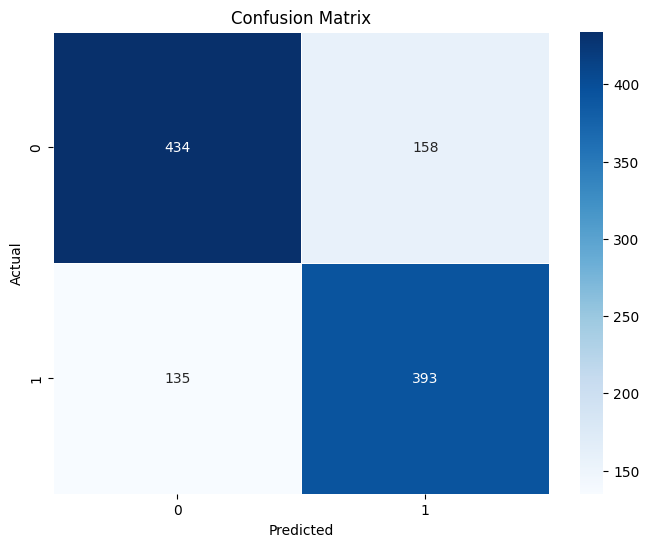


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.73      0.75       592
           1       0.71      0.74      0.73       528

    accuracy                           0.74      1120
   macro avg       0.74      0.74      0.74      1120
weighted avg       0.74      0.74      0.74      1120

Acurácia no conjunto de teste: 73.84%


,nm_prop_oportunidade,convertido,probabilidade_conversao,id_quote
0,adryson pinto freitas,1,0.500580,0Q03s000000SgjJCAS
1,ana paula goncalves lemos,1,0.505818,0Q03s000000GbRDCA0
2,bruno schmelzer de souza,0,0.492297,0Q03s000000GSpmCAG
3,claudia marina silva,0,0.463150,0Q03s000000GUhUCAW
4,dara jenifer de jesus,1,0.511115,0Q03s000000SYHxCAO
5,ediane rosa,0,0.447332,0Q03s000000SgIICA0
6,fabiano martins werutsky,1,0.553361,0Q03s000000GRwXCAW
7,juliana westphalen gonçalves,0,0.493253,0Q03s000000GS97CAG
8,leticia silva de arruda,1,0.507844,0Q03s000000GRoxCAG
9,luis roberto da silva ferreira junior,1,0.549631,0Q03s000000GSIiCAO


In [10]:


categoricos = ['id_quote', 'dt_criacao', 'ds_tipo_obra', 'nm_prop_oportunidade', 'proprietario', 'promocional',
               'tipo_loja', 'banheiro', 'toda_casa', 'cozinha', 'area_externa', 'itens_assentamento', 'sala',
               'piscina', 'area_servico', 'garagem', 'dormitorio', 'varanda', 'escada', 'amb_outros']

encoder = OneHotEncoder(drop='if_binary')
df_encoded = pd.DataFrame(encoder.fit_transform(base_treino[categoricos]).toarray(),
                          columns=encoder.get_feature_names_out(categoricos))
df_final = pd.concat([base_treino.drop(categoricos, axis=1), df_encoded], axis=1)

X = df_final.drop('convertido', axis=1)
y = df_final['convertido']

var_threshold = 0.40
selector = VarianceThreshold(threshold=(var_threshold * (1 - var_threshold)))
X_high_variance = selector.fit_transform(X)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

x_treino, x_teste, y_treino, y_teste = train_test_split(X_high_variance, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_treino = scaler.fit_transform(x_treino)
x_teste = scaler.transform(x_teste)

smote = SMOTE(random_state=42)
x_treino_resampled, y_treino_resampled = smote.fit_resample(x_treino, y_treino)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 3, 5],
}

grad_boost = GradientBoostingClassifier()

grid_search = GridSearchCV(grad_boost, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(x_treino_resampled, y_treino_resampled)

best_params = grid_search.best_params_

modelo_grad_boost = GradientBoostingClassifier(**best_params)
modelo_grad_boost.fit(x_treino_resampled, y_treino_resampled)

y_pred = modelo_grad_boost.predict(x_teste)
matriz_confusao = confusion_matrix(y_teste, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(y_teste, y_pred))

acuracia = accuracy_score(y_teste, y_pred)
print(f'Acurácia no conjunto de teste: {acuracia * 100:.2f}%')

probabilidades_teste = modelo_grad_boost.predict_proba(x_teste)[:, 1]

x_teste_df = pd.DataFrame(x_teste, columns=X.columns[selector.get_support()])
df_temporario_teste = pd.DataFrame({
    'nm_prop_oportunidade': base_treino.loc[x_teste_df.index, 'nm_prop_oportunidade'],
    'convertido': y_teste,
    'id_quote': base_treino.loc[x_teste_df.index, 'id_quote'],
    'probabilidade_conversao': probabilidades_teste
})

df_temporario_teste = df_temporario_teste.drop_duplicates(subset=['nm_prop_oportunidade', 'convertido', 'id_quote'])

df_resultados_teste = df_temporario_teste.groupby('nm_prop_oportunidade', as_index=False).agg({
    'convertido': 'first',
    'probabilidade_conversao': 'mean',
    'id_quote': 'first' 
})

with pd.option_context('display.max_rows', None):
    display(df_resultados_teste[['nm_prop_oportunidade', 'convertido', 'probabilidade_conversao', 'id_quote']])


In [11]:
df_resultados_teste.to_csv("orcamentos_gradienteboosting_Classifier.csv")